# MODULE 1 : IMBALANCED LEARNING

---

### libraries

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import StandardScaler, MinMaxScaler, label_binarize
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, CondensedNearestNeighbour, EditedNearestNeighbours, ClusterCentroids
from sklearn.cluster import MiniBatchKMeans
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.tree._tree import TREE_LEAF
from imblearn.combine import SMOTEENN

### 0) Data Visualization

seleziono la feature target: **groupedTitleType = {Series, movie, short, other}**

In [19]:
"""
# =============================================================================
# PART 1: Data Loading, Preprocessing & Normalization (Common for Both Models)
# =============================================================================

# 1. Load the preprocessed dataset from CSV
data = pd.read_csv("../0) dataset/1) preprocessed dataset/imdb.csv")
data.drop(columns='Unnamed: 0',inplace=True)
target = "groupedTitleType"  # Target variable

# 2. Extract numerical columns dynamically
attributes = list(np.unique(data.select_dtypes(include=['int', 'float64']).columns))

# 3. Remove unwanted one-hot encoded columns and any other non-useful features
unwanted_values = {'Series', 'movie', 'short', 'other', 'rating'}
attributes = [attr for attr in attributes if attr not in unwanted_values]
print("Initial numerical features:", attributes)

# 4. Define the feature matrix (X) and target vector (y)
X = data[attributes].values
y = data[target].values

# 5. Split the dataset into training and testing sets (25% test split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# 6. Normalize the features using StandardScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
"""

'\n# =============================================================================\n# PART 1: Data Loading, Preprocessing & Normalization (Common for Both Models)\n# =============================================================================\n\n# 1. Load the preprocessed dataset from CSV\ndata = pd.read_csv("../0) dataset/1) preprocessed dataset/imdb.csv")\ndata.drop(columns=\'Unnamed: 0\',inplace=True)\ntarget = "groupedTitleType"  # Target variable\n\n# 2. Extract numerical columns dynamically\nattributes = list(np.unique(data.select_dtypes(include=[\'int\', \'float64\']).columns))\n\n# 3. Remove unwanted one-hot encoded columns and any other non-useful features\nunwanted_values = {\'Series\', \'movie\', \'short\', \'other\', \'rating\'}\nattributes = [attr for attr in attributes if attr not in unwanted_values]\nprint("Initial numerical features:", attributes)\n\n# 4. Define the feature matrix (X) and target vector (y)\nX = data[attributes].values\ny = data[target].values\n\n# 5. S

In [20]:
# =============================================================================
# PART 1: Data Loading, Preprocessing & Normalization (Common for Both Models)
# =============================================================================

# 1. Load the preprocessed train and test datasets from CSV
train_data = pd.read_csv("../0) dataset/2) preprocessed e outliers dataset/train.csv")
test_data  = pd.read_csv("../0) dataset/2) preprocessed e outliers dataset/test.csv")

# Drop the 'Unnamed: 0' column if it exists
train_data.drop(columns='Unnamed: 0', inplace=True, errors='ignore')
test_data.drop(columns='Unnamed: 0', inplace=True, errors='ignore')

# Define the target variable
target = "groupedTitleType"

# 2. Extract numerical columns dynamically from the training set
attributes = list(np.unique(train_data.select_dtypes(include=['int', 'float64']).columns))

# 3. Remove unwanted one-hot encoded columns and any other non-useful features
unwanted_values = {'Series', 'movie', 'short', 'other', 'rating'}
attributes = [attr for attr in attributes if attr not in unwanted_values]
print("Initial numerical features:", attributes)

# 4. Define the feature matrix (X) and target vector (y) for both train and test sets
X_train = train_data[attributes].values
y_train = train_data[target].values

X_test  = test_data[attributes].values
y_test  = test_data[target].values

# 5. Normalize the features using StandardScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

Initial numerical features: ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Short', 'averageRating', 'awardNominationsExcludeWinsLog', 'awardWinsLog', 'castNumberLog', 'companiesNumberLog', 'criticReviewsTotalLog', 'directorsCreditsLog', 'externalLinksLog', 'isAdult', 'numRegionsLog', 'numVotesLog', 'others', 'quotesTotalLog', 'ratingCountLog', 'runtimeMinutes', 'startYear', 'totalCreditsLog', 'totalImagesLog', 'totalVideosLog', 'userReviewsTotalLog', 'writerCreditsLog']


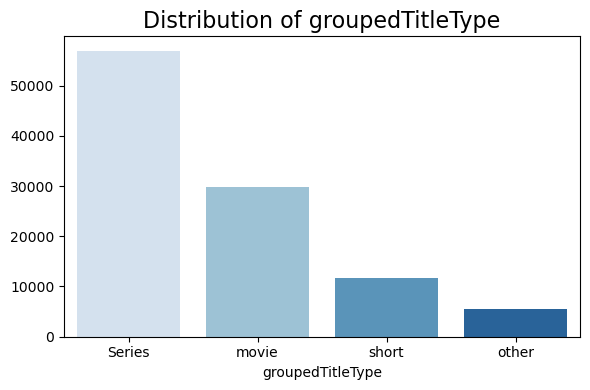

In [21]:
# Plot the target class distribution using training data
target_counts = train_data[target].value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts.index, y=target_counts.values, hue=target_counts.index, palette='Blues', legend=False)
plt.title("Distribution of groupedTitleType", fontsize=16)
plt.tight_layout()
plt.show()

### 1) normal ML models execution

proviamo **DT** e **KNN** sul dataset normale per vedere le loro performance a monte

### 1.1) DT


Best hyperparameters for DT: {'min_samples_split': 50, 'min_samples_leaf': 20, 'max_depth': 15, 'criterion': 'entropy'}
Best cross-validated score for DT: 0.9356383367153114

Decision Tree Classifier Report:
              precision    recall  f1-score   support

      Series       0.95      0.89      0.92     24448
       movie       0.78      0.93      0.85     12788
       other       0.51      0.38      0.44      2422
       short       0.94      0.87      0.90      5005

    accuracy                           0.87     44663
   macro avg       0.80      0.77      0.78     44663
weighted avg       0.88      0.87      0.87     44663



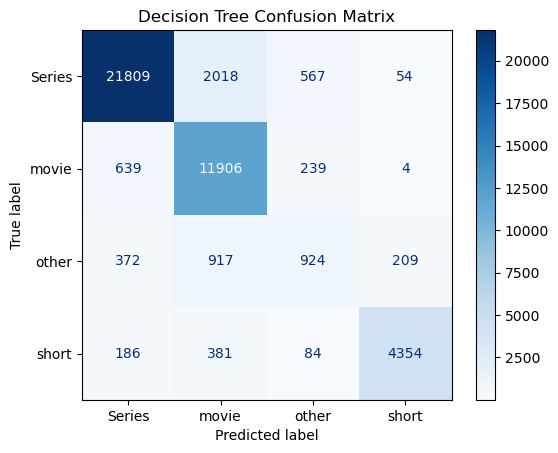

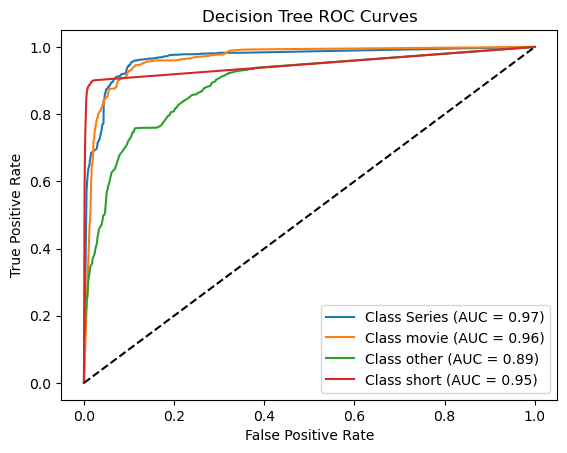

In [22]:
# =============================================================================
# PART 2: Decision Tree Classifier with Normalization & Robust Hyperparameter Tuning
# =============================================================================

"""
# --- Step A: Initial Feature Importance Analysis using DT ---
# Create and fit a baseline Decision Tree on the normalized training set
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_scaled, y_train)

# Zip feature names with their corresponding importances and sort them in descending order
zipped = sorted(zip(attributes, dt.feature_importances_), key=lambda x: x[1], reverse=True)

print("\nFeature importances from initial DT model:")
selected_features_dt = []  # To store features with importance above threshold
for col, imp in zipped:
    print(f"{col}: {imp*100:.2f}%")
    # Select features with importance above threshold (here, > 0.5%)
    if imp > 0.005:
        selected_features_dt.append(col)

print("Selected features for DT (importance > 0.5%):", selected_features_dt)
"""

# Instead, we use these manually selected features:
selected_features_dt = ['runtimeMinutes', 'Short', 'numRegionsLog', 'directorsCreditsLog', 'startYear', 'totalCreditsLog', 'averageRating', 'isAdult', 'castNumberLog', 'companiesNumberLog', 'externalLinksLog', 'numVotesLog', 'writerCreditsLog', 'ratingCountLog', 'totalImagesLog', 'Drama', 'Documentary', 'others']

# --- Step B: Re-prepare the dataset using only the selected features ---
# Extract selected features from the train and test datasets
X_train_dt = train_data[selected_features_dt].values
y_train_dt = train_data[target].values

X_test_dt = test_data[selected_features_dt].values
y_test_dt = test_data[target].values

# Normalize the selected features using MinMaxScaler (for consistency)
scaler_dt = MinMaxScaler()
X_train_dt_scaled = scaler_dt.fit_transform(X_train_dt)
X_test_dt_scaled = scaler_dt.transform(X_test_dt)

# --- Step C: Hyperparameter Tuning for Decision Tree using RandomizedSearchCV ---
param_grid_dt = {
    'max_depth': [None] + list(np.arange(2, 20)),
    'min_samples_split': [10, 20, 50, 100],
    'min_samples_leaf': [5, 10, 20],
    'criterion': ['gini', 'entropy']
}

random_search_dt = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_distributions=param_grid_dt,
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42),
    n_jobs=-1,
    refit=True,
    n_iter=30,
    scoring='accuracy'
)
random_search_dt.fit(X_train_dt_scaled, y_train_dt)

print("\nBest hyperparameters for DT:", random_search_dt.best_params_)
print("Best cross-validated score for DT:", random_search_dt.best_score_)

# Set best_params_dt to those found by random search
best_params_dt = random_search_dt.best_params_

"""
# Instead, define the best hyperparameters (from previous RandomizedSearchCV results)
best_params_dt = {
    'min_samples_split': 10,
    'min_samples_leaf': 10,
    'max_depth': 14,
    'criterion': 'entropy',
    'random_state': 42
}
"""

# --- Step D: Train and Evaluate the Final Decision Tree Model ---
# Initialize and train the final Decision Tree model using the best parameters
best_dt = DecisionTreeClassifier(**best_params_dt, random_state=42)
best_dt.fit(X_train_dt_scaled, y_train_dt)

# Evaluate the final model on the test set
y_pred_dt = best_dt.predict(X_test_dt_scaled)
print("\nDecision Tree Classifier Report:")
print(classification_report(y_test_dt, y_pred_dt))

# Plot and display the confusion matrix for the Decision Tree
cm_dt = confusion_matrix(y_test_dt, y_pred_dt)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=best_dt.classes_)
disp_dt.plot(cmap='Blues')
plt.title("Decision Tree Confusion Matrix")
plt.show()

# Binarize the true labels for DT (multiclass ROC requires binarization)
classes_dt = best_dt.classes_
y_test_dt_bin = label_binarize(y_test_dt, classes=classes_dt)
y_score_dt = best_dt.predict_proba(X_test_dt_scaled)

# Compute ROC curve and AUC for each class
fpr_dt, tpr_dt, roc_auc_dt = dict(), dict(), dict()
for i, cls in enumerate(classes_dt):
    fpr_dt[i], tpr_dt[i], _ = roc_curve(y_test_dt_bin[:, i], y_score_dt[:, i])
    roc_auc_dt[i] = auc(fpr_dt[i], tpr_dt[i])

# Plot the ROC curves for DT
plt.figure()
for i, cls in enumerate(classes_dt):
    plt.plot(fpr_dt[i], tpr_dt[i], label=f'Class {cls} (AUC = {roc_auc_dt[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Decision Tree ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [23]:
# =============================================================================
# PART 2: Decision Tree Classifier with Normalization, PCA & Robust Hyperparameter Tuning
# =============================================================================
"""
# Number of PCA components retained: 15

# --- Step A: Dimensionality Reduction using PCA ---
# Apply PCA on the normalized training set (X_train_scaled) to retain 95% variance
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)
print("Number of PCA components retained:", pca.n_components_)

# --- Step B: Define Fixed Best Hyperparameters for Decision Tree ---
# (Best parameters obtained previously from RandomizedSearchCV)
best_params_dt = {
    'min_samples_split': 10,
    'min_samples_leaf': 10,
    'max_depth': 14,
    'criterion': 'entropy',
    'random_state': 42
}

# --- Step C: Train and Evaluate the Decision Tree Model ---
# Train the Decision Tree on the PCA-transformed training data
best_dt = DecisionTreeClassifier(**best_params_dt)
best_dt.fit(X_train_pca, y_train)

# Predict on the PCA-transformed test set
y_pred_dt = best_dt.predict(X_test_pca)
print("\nDecision Tree Classifier Report:")
print(classification_report(y_test_dt, y_pred_dt))

# Plot the confusion matrix
cm_dt = confusion_matrix(y_test_dt, y_pred_dt)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=best_dt.classes_)
disp_dt.plot(cmap='Blues')
plt.title("Decision Tree Confusion Matrix")
plt.show()

# --- Step D: Plot ROC Curves for the Decision Tree ---
# Binarize the true labels (for multiclass ROC, we need a binary format)
classes_dt = best_dt.classes_
y_test_dt_bin = label_binarize(y_test_dt, classes=classes_dt)
y_score_dt = best_dt.predict_proba(X_test_pca)

# Compute ROC curve and AUC for each class
fpr_dt, tpr_dt, roc_auc_dt = {}, {}, {}
for i, cls in enumerate(classes_dt):
    fpr_dt[i], tpr_dt[i], _ = roc_curve(y_test_dt_bin[:, i], y_score_dt[:, i])
    roc_auc_dt[i] = auc(fpr_dt[i], tpr_dt[i])

# Plot all ROC curves on one figure
plt.figure()
for i, cls in enumerate(classes_dt):
    plt.plot(fpr_dt[i], tpr_dt[i], label=f'Class {cls} (AUC = {roc_auc_dt[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Decision Tree ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()
"""

'\n# Number of PCA components retained: 15\n\n# --- Step A: Dimensionality Reduction using PCA ---\n# Apply PCA on the normalized training set (X_train_scaled) to retain 95% variance\npca = PCA(n_components=0.95, random_state=42)\nX_train_pca = pca.fit_transform(X_train_scaled)\nX_test_pca  = pca.transform(X_test_scaled)\nprint("Number of PCA components retained:", pca.n_components_)\n\n# --- Step B: Define Fixed Best Hyperparameters for Decision Tree ---\n# (Best parameters obtained previously from RandomizedSearchCV)\nbest_params_dt = {\n    \'min_samples_split\': 10,\n    \'min_samples_leaf\': 10,\n    \'max_depth\': 14,\n    \'criterion\': \'entropy\',\n    \'random_state\': 42\n}\n\n# --- Step C: Train and Evaluate the Decision Tree Model ---\n# Train the Decision Tree on the PCA-transformed training data\nbest_dt = DecisionTreeClassifier(**best_params_dt)\nbest_dt.fit(X_train_pca, y_train)\n\n# Predict on the PCA-transformed test set\ny_pred_dt = best_dt.predict(X_test_pca)\nprin

### 1.2) KNN

In [24]:
# =============================================================================
# PART 3: Optimized KNN Classifier with Fast Hyperparameter Tuning
# =============================================================================

"""
# -> Trial 5 finished with value: 0.9124758885697165 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'p': 1}. Best is trial 5 with value: 0.9124758885697165.
# -> Selected features for KNN: ['Short', 'directorsCreditsLog', 'isAdult', 'numRegionsLog', 'runtimeMinutes']

# --- Step B: Feature Selection using Sequential Feature Selector (SFS) ---
knn = KNeighborsClassifier()

# Select top 5 best features using forward selection (cv=3 for speed)
sfs = SequentialFeatureSelector(knn, n_features_to_select=5, direction='forward', scoring='accuracy', cv=3, n_jobs=-1)
sfs.fit(X_train_scaled, y_train)

# Retrieve indices and names of selected features
selected_idx_knn = sfs.get_support(indices=True)
selected_features_knn = [attributes[i] for i in selected_idx_knn]
print("\nSelected features for KNN:", selected_features_knn)

# Transform dataset to keep only selected features
X_train_knn = sfs.transform(X_train_scaled)
X_test_knn = sfs.transform(X_test_scaled)


# --- Step A: Use Pre-selected Features ---
# The SFS process was too time consuming.
# Pre-selected features (from previous SFS run):
# selected_features_knn = ['Short', 'directorsCreditsLog', 'isAdult', 'numRegionsLog', 'runtimeMinutes', 'startYear', 'averageRating', 'numVotesLog']
selected_features_knn = ['runtimeMinutes', 'Short', 'numRegionsLog', 'directorsCreditsLog', 'startYear', 'totalCreditsLog', 'averageRating', 'isAdult', 'castNumberLog', 'companiesNumberLog', 'externalLinksLog', 'numVotesLog', 'writerCreditsLog', 'ratingCountLog', 'totalImagesLog', 'Drama', 'Documentary', 'others']

# Assume that 'attributes' is the full list of feature names corresponding to the columns in X_train_scaled.
# Obtain indices of the selected features from the complete feature list.
selected_indices_knn = [attributes.index(feat) for feat in selected_features_knn]

# Transform the dataset to keep only the pre-selected features
X_train_knn = X_train_scaled[:, selected_indices_knn]
X_test_knn  = X_test_scaled[:, selected_indices_knn]

# --- Step B: Hyperparameter Tuning (Commented Out) ---
# Option 1: Fast Tuning using HalvingRandomSearchCV
param_grid_knn = {
    'n_neighbors': list(range(3, 21, 2)),  # Odd numbers from 3 to 19
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1: Manhattan, 2: Euclidean
}
halving_search_knn = HalvingRandomSearchCV(
    KNeighborsClassifier(),
    param_distributions=param_grid_knn,
    factor=2,
    cv=3,
    min_resources='exhaust',
    n_jobs=-1,
    scoring='accuracy',
    random_state=42
)
halving_search_knn.fit(X_train_knn, y_train)
print("\nBest hyperparameters for KNN (Halving Random Search):", halving_search_knn.best_params_)

# Option 2: Hyperparameter Tuning using Optuna
def objective(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 3, 19, step=2)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    p = trial.suggest_int('p', 1, 2)
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=p)
    score = cross_val_score(knn, X_train_knn, y_train, cv=3, scoring='accuracy').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)
print("\nBest hyperparameters for KNN (Optuna):", study.best_params_)

# Instead, we directly define the best hyperparameters (from Trial 5):
best_params_knn = {'n_neighbors': 19, 'weights': 'uniform', 'p': 1}

# --- Step C: Train Final KNN Model ---
best_knn = KNeighborsClassifier(**best_params_knn)
best_knn.fit(X_train_knn, y_train)

# --- Step D: Evaluate Model Performance ---
y_pred_knn = best_knn.predict(X_test_knn)

print("\nKNN Classifier Report:")
print(classification_report(y_test, y_pred_knn))

# Plot and display the confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=best_knn.classes_)
disp_knn.plot(cmap='Blues')
plt.title("KNN Confusion Matrix")
plt.show()

# Binarize the true labels for KNN
classes_knn = best_knn.classes_
y_test_knn_bin = label_binarize(y_test, classes=classes_knn)
y_score_knn = best_knn.predict_proba(X_test_knn)

# Compute ROC curve and AUC for each class
fpr_knn, tpr_knn, roc_auc_knn = dict(), dict(), dict()
for i, cls in enumerate(classes_knn):
    fpr_knn[i], tpr_knn[i], _ = roc_curve(y_test_knn_bin[:, i], y_score_knn[:, i])
    roc_auc_knn[i] = auc(fpr_knn[i], tpr_knn[i])

# Plot the ROC curves for KNN
plt.figure()
for i, cls in enumerate(classes_knn):
    plt.plot(fpr_knn[i], tpr_knn[i], label=f'Class {cls} (AUC = {roc_auc_knn[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("KNN ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()
"""

'\n# -> Trial 5 finished with value: 0.9124758885697165 and parameters: {\'n_neighbors\': 19, \'weights\': \'uniform\', \'p\': 1}. Best is trial 5 with value: 0.9124758885697165.\n# -> Selected features for KNN: [\'Short\', \'directorsCreditsLog\', \'isAdult\', \'numRegionsLog\', \'runtimeMinutes\']\n\n# --- Step B: Feature Selection using Sequential Feature Selector (SFS) ---\nknn = KNeighborsClassifier()\n\n# Select top 5 best features using forward selection (cv=3 for speed)\nsfs = SequentialFeatureSelector(knn, n_features_to_select=5, direction=\'forward\', scoring=\'accuracy\', cv=3, n_jobs=-1)\nsfs.fit(X_train_scaled, y_train)\n\n# Retrieve indices and names of selected features\nselected_idx_knn = sfs.get_support(indices=True)\nselected_features_knn = [attributes[i] for i in selected_idx_knn]\nprint("\nSelected features for KNN:", selected_features_knn)\n\n# Transform dataset to keep only selected features\nX_train_knn = sfs.transform(X_train_scaled)\nX_test_knn = sfs.transform(

---

### 2) imbalanced learning ML models execution

In [25]:
selected_features_dt = ['runtimeMinutes', 'Short', 'numRegionsLog', 'directorsCreditsLog', 'startYear', 'totalCreditsLog', 'averageRating', 'isAdult', 'castNumberLog', 'companiesNumberLog', 'externalLinksLog', 'numVotesLog', 'writerCreditsLog', 'ratingCountLog', 'totalImagesLog', 'Drama', 'Documentary', 'others']
# best_params_dt = { 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_depth': 14, 'criterion': 'entropy', 'random_state': 42 }

### 2.1) UnderSampling

### 2.2.1) Random UnderSampling

Class distribution after RUS:
Series    5612
movie     5612
other     5612
short     5612
Name: count, dtype: int64


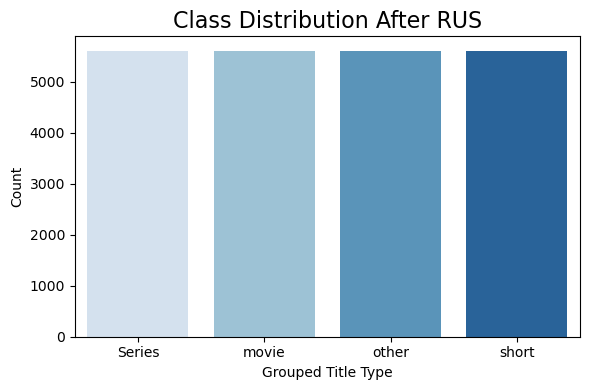


Best hyperparameters found: {'min_samples_split': 50, 'min_samples_leaf': 10, 'max_depth': 18, 'criterion': 'gini'}

Decision Tree Classifier Report (After RUS):
              precision    recall  f1-score   support

      Series       0.97      0.71      0.82     24448
       movie       0.73      0.85      0.79     12788
       other       0.25      0.70      0.36      2422
       short       0.92      0.91      0.92      5005

    accuracy                           0.77     44663
   macro avg       0.72      0.79      0.72     44663
weighted avg       0.86      0.77      0.80     44663



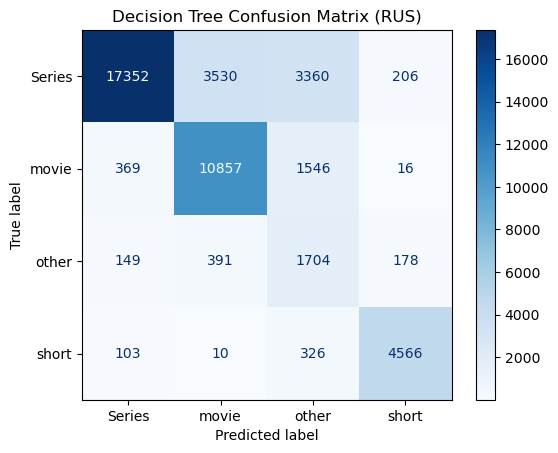

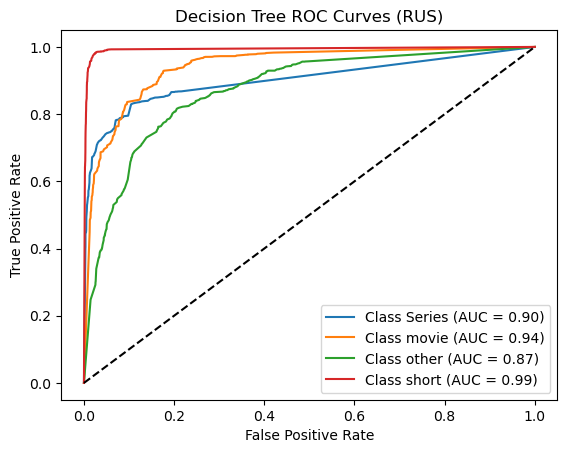

In [26]:
# =============================================================================
# Handling Class Imbalance with Random Undersampling (RUS)
# =============================================================================
rus = RandomUnderSampler(random_state=42)
X_res_rus, y_res_rus = rus.fit_resample(X_train_dt_scaled, y_train_dt)

# ----- Plot Undersampled Target Distribution -----
print("Class distribution after RUS:")
print(pd.Series(y_res_rus).value_counts())
target_counts_after = pd.Series(y_res_rus).value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts_after.index, y=target_counts_after.values, hue=target_counts_after.index, palette='Blues', legend=False)
plt.title("Class Distribution After RUS", fontsize=16)
plt.xlabel("Grouped Title Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# =============================================================================
# Hyperparameter Tuning using RandomizedSearchCV on RUS Data
# =============================================================================
param_grid_dt = {
    'max_depth': [None] + list(range(2, 20)),
    'min_samples_split': [10, 20, 50, 100],
    'min_samples_leaf': [5, 10, 20],
    'criterion': ['gini', 'entropy']
}

random_search = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_distributions=param_grid_dt,
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42),
    n_jobs=-1,
    refit=True,
    n_iter=30,
    scoring='accuracy'
)
random_search.fit(X_res_rus, y_res_rus)
best_params_dt = random_search.best_params_
print("\nBest hyperparameters found:", best_params_dt)

# =============================================================================
# Train & Evaluate Decision Tree Classifier After RUS with Best Parameters
# =============================================================================
# Create new instance of DT with best hyperparameters (new variable name: best_dt_rus)
best_dt_rus = DecisionTreeClassifier(**best_params_dt, random_state=42)
best_dt_rus.fit(X_res_rus, y_res_rus)

# Predict on the test set
y_pred_dt_rus = best_dt_rus.predict(X_test_dt_scaled)

print("\nDecision Tree Classifier Report (After RUS):")
print(classification_report(y_test_dt, y_pred_dt_rus))

# Plot Confusion Matrix
cm_rus = confusion_matrix(y_test_dt, y_pred_dt_rus)
disp_rus = ConfusionMatrixDisplay(confusion_matrix=cm_rus, display_labels=best_dt_rus.classes_)
disp_rus.plot(cmap='Blues')
plt.title("Decision Tree Confusion Matrix (RUS)")
plt.show()

# =============================================================================
# ROC Curve Evaluation for the RUS Model
# =============================================================================
# Binarize the true labels (for multiclass ROC computation)
classes_rus = best_dt_rus.classes_
y_test_bin_rus = label_binarize(y_test_dt, classes=classes_rus)
y_score_rus = best_dt_rus.predict_proba(X_test_dt_scaled)

plt.figure()
for i, cls in enumerate(classes_rus):
    fpr, tpr, _ = roc_curve(y_test_bin_rus[:, i], y_score_rus[:, i])
    plt.plot(fpr, tpr, label=f'Class {cls} (AUC = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Decision Tree ROC Curves (RUS)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

### 2.2.2) Tomek Links

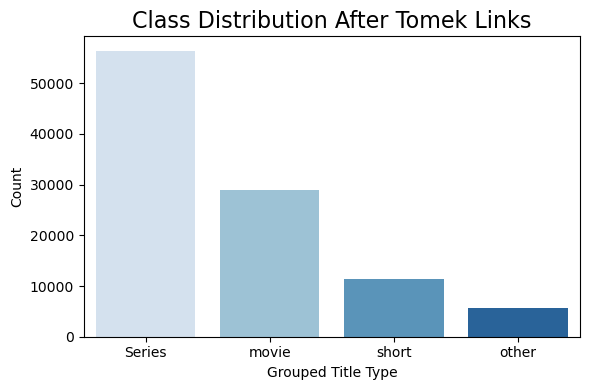


Best hyperparameters for DT after Tomek Links: {'min_samples_split': 20, 'min_samples_leaf': 20, 'max_depth': 16, 'criterion': 'entropy'}

Decision Tree Classifier Report (After Tomek Links):
              precision    recall  f1-score   support

      Series       0.95      0.91      0.93     24448
       movie       0.81      0.93      0.86     12788
       other       0.59      0.43      0.50      2422
       short       0.94      0.87      0.90      5005

    accuracy                           0.88     44663
   macro avg       0.82      0.78      0.80     44663
weighted avg       0.89      0.88      0.88     44663



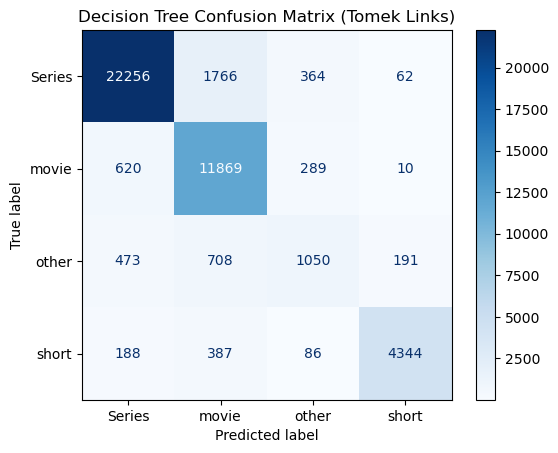

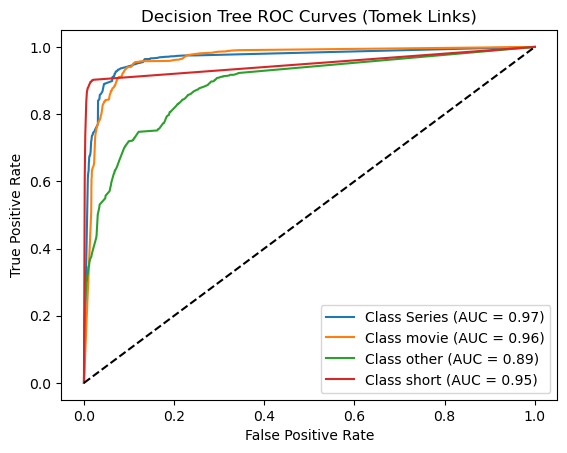

In [27]:
# =============================================================================
# Step 1: Apply Tomek Links Undersampling
# =============================================================================
tl = TomekLinks()
X_res_tl, y_res_tl = tl.fit_resample(X_train_dt_scaled, y_train_dt)

# =============================================================================
# Step 2: Plot Class Distribution After Tomek Links
# =============================================================================
target_counts_tl = pd.Series(y_res_tl).value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts_tl.index, y=target_counts_tl.values, hue=target_counts_tl.index, palette='Blues', legend=False)
plt.title("Class Distribution After Tomek Links", fontsize=16)
plt.xlabel("Grouped Title Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# =============================================================================
# Step 3: Hyperparameter Tuning Using RandomizedSearchCV
# =============================================================================
param_grid_dt = {
    'max_depth': [None] + list(range(2, 20)),
    'min_samples_split': [10, 20, 50, 100],
    'min_samples_leaf': [5, 10, 20],
    'criterion': ['gini', 'entropy']
}

random_search_tl = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_distributions=param_grid_dt,
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42),
    n_jobs=-1,
    refit=True,
    n_iter=30,
    scoring='accuracy'
)
random_search_tl.fit(X_res_tl, y_res_tl)
best_params_tl = random_search_tl.best_params_
print("\nBest hyperparameters for DT after Tomek Links:", best_params_tl)

# =============================================================================
# Step 4: Train & Evaluate Decision Tree Classifier Using New Best Parameters
# =============================================================================
best_dt_tl = DecisionTreeClassifier(**best_params_tl, random_state=42)
best_dt_tl.fit(X_res_tl, y_res_tl)
y_pred_tl = best_dt_tl.predict(X_test_dt_scaled)

print("\nDecision Tree Classifier Report (After Tomek Links):")
print(classification_report(y_test_dt, y_pred_tl))

# =============================================================================
# Step 5: Plot Confusion Matrix
# =============================================================================
cm_tl = confusion_matrix(y_test_dt, y_pred_tl)
disp_tl = ConfusionMatrixDisplay(confusion_matrix=cm_tl, display_labels=best_dt_tl.classes_)
disp_tl.plot(cmap='Blues')
plt.title("Decision Tree Confusion Matrix (Tomek Links)")
plt.show()

# =============================================================================
# Step 6: Plot ROC Curves for the Model
# =============================================================================
y_test_bin_tl = label_binarize(y_test_dt, classes=best_dt_tl.classes_)
y_score_tl = best_dt_tl.predict_proba(X_test_dt_scaled)

plt.figure()
for i, cls in enumerate(best_dt_tl.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin_tl[:, i], y_score_tl[:, i])
    plt.plot(fpr, tpr, label=f'Class {cls} (AUC = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Decision Tree ROC Curves (Tomek Links)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

### 2.2.3) Edited Nearest Neighbors

Class distribution after ENN:
Series    53545
movie     24383
short      9852
other      5612
Name: count, dtype: int64


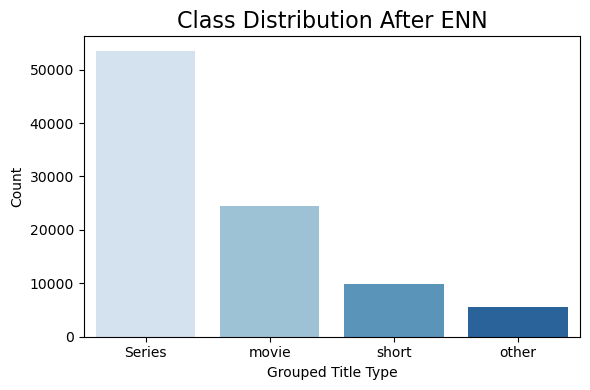


Best hyperparameters for DT after ENN: {'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 14, 'criterion': 'entropy'}

Decision Tree Classifier Report (After ENN):
              precision    recall  f1-score   support

      Series       0.95      0.81      0.87     24448
       movie       0.80      0.90      0.85     12788
       other       0.28      0.59      0.38      2422
       short       0.95      0.83      0.89      5005

    accuracy                           0.83     44663
   macro avg       0.75      0.78      0.75     44663
weighted avg       0.87      0.83      0.84     44663



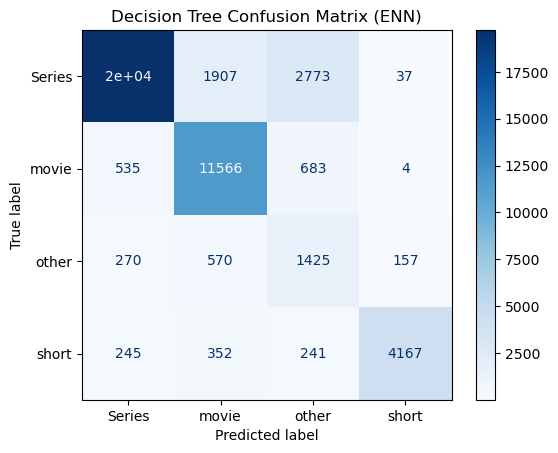

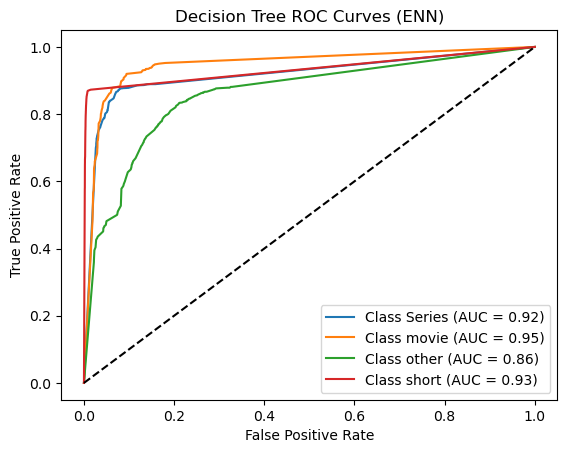

In [28]:
# =============================================================================
# Step 1: Apply Edited Nearest Neighbors (ENN) Undersampling
# =============================================================================
enn = EditedNearestNeighbours()
X_res_enn, y_res_enn = enn.fit_resample(X_train_dt_scaled, y_train_dt)

# =============================================================================
# Step 2: Plot Class Distribution After ENN
# =============================================================================
print("Class distribution after ENN:")
print(pd.Series(y_res_enn).value_counts())
target_counts_enn = pd.Series(y_res_enn).value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts_enn.index, y=target_counts_enn.values, hue=target_counts_enn.index, palette='Blues', legend=False)
plt.title("Class Distribution After ENN", fontsize=16)
plt.xlabel("Grouped Title Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# =============================================================================
# Step 3: Hyperparameter Tuning Using RandomizedSearchCV
# =============================================================================
param_grid_dt = {
    'max_depth': [None] + list(range(2, 20)),
    'min_samples_split': [10, 20, 50, 100],
    'min_samples_leaf': [5, 10, 20],
    'criterion': ['gini', 'entropy']
}

random_search_enn = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_distributions=param_grid_dt,
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42),
    n_jobs=-1,
    refit=True,
    n_iter=30,
    scoring='accuracy'
)
random_search_enn.fit(X_res_enn, y_res_enn)
best_params_enn = random_search_enn.best_params_
print("\nBest hyperparameters for DT after ENN:", best_params_enn)

# =============================================================================
# Step 4: Train & Evaluate Decision Tree Classifier Using ENN Data
# =============================================================================
# Train a new DT model with the tuned hyperparameters (new variable: best_dt_enn)
best_dt_enn = DecisionTreeClassifier(**best_params_enn, random_state=42)
best_dt_enn.fit(X_res_enn, y_res_enn)

# Predict on the test set
y_pred_dt_enn = best_dt_enn.predict(X_test_dt_scaled)

print("\nDecision Tree Classifier Report (After ENN):")
print(classification_report(y_test_dt, y_pred_dt_enn))

# =============================================================================
# Step 5: Plot Confusion Matrix
# =============================================================================
cm_enn = confusion_matrix(y_test_dt, y_pred_dt_enn)
disp_enn = ConfusionMatrixDisplay(confusion_matrix=cm_enn, display_labels=best_dt_enn.classes_)
disp_enn.plot(cmap='Blues')
plt.title("Decision Tree Confusion Matrix (ENN)")
plt.show()

# =============================================================================
# Step 6: Plot ROC Curves for the ENN Model
# =============================================================================
# Binarize the true labels for multiclass ROC computation
classes_enn = best_dt_enn.classes_
y_test_bin_enn = label_binarize(y_test_dt, classes=classes_enn)
y_score_enn = best_dt_enn.predict_proba(X_test_dt_scaled)

plt.figure()
for i, cls in enumerate(classes_enn):
    fpr, tpr, _ = roc_curve(y_test_bin_enn[:, i], y_score_enn[:, i])
    plt.plot(fpr, tpr, label=f'Class {cls} (AUC = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Decision Tree ROC Curves (ENN)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

### 2.2.4) Condensed Nearest Neighbors

In [32]:
"""
# =============================================================================
# Step 1: Apply Condensed Nearest Neighbours (CNN) Undersampling
# =============================================================================
cnn = CondensedNearestNeighbour(random_state=42)
X_res_cnn, y_res_cnn = cnn.fit_resample(X_train_dt_scaled, y_train_dt)

# =============================================================================
# Step 2: Plot Class Distribution After CNN
# =============================================================================
target_counts_cnn = pd.Series(y_res_cnn).value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts_cnn.index, y=target_counts_cnn.values, hue=target_counts_cnn.index, palette='Blues', legend=False)
plt.title("Class Distribution After Condensed Nearest Neighbours", fontsize=16)
plt.xlabel("Grouped Title Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# =============================================================================
# Step 3: Hyperparameter Tuning Using RandomizedSearchCV
# =============================================================================
"""
"""
param_grid_dt = {
    'max_depth': [None] + list(range(2, 20)),
    'min_samples_split': [10, 20, 50, 100],
    'min_samples_leaf': [5, 10, 20],
    'criterion': ['gini', 'entropy']
}

random_search_cnn = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_distributions=param_grid_dt,
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42),
    n_jobs=-1,
    refit=True,
    n_iter=30,
    scoring='accuracy'
)
random_search_cnn.fit(X_res_cnn, y_res_cnn)
best_params_cnn = random_search_cnn.best_params_
print("\nBest hyperparameters for DT after Condensed Nearest Neighbours:", best_params_cnn)
"""
"""

best_params_cnn = {'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 14, 'criterion': 'entropy'}

# =============================================================================
# Step 4: Train & Evaluate Decision Tree Classifier Using CNN Data
# =============================================================================
best_dt_cnn = DecisionTreeClassifier(**best_params_cnn, random_state=42)
best_dt_cnn.fit(X_res_cnn, y_res_cnn)
y_pred_dt_cnn = best_dt_cnn.predict(X_test_dt_scaled)

print("\nDecision Tree Classifier Report (After CNN):")
print(classification_report(y_test_dt, y_pred_dt_cnn))

# =============================================================================
# Step 5: Plot Confusion Matrix
# =============================================================================
cm_cnn = confusion_matrix(y_test_dt, y_pred_dt_cnn)
disp_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=best_dt_cnn.classes_)
disp_cnn.plot(cmap='Blues')
plt.title("Decision Tree Confusion Matrix (CNN)")
plt.show()

# =============================================================================
# Step 6: Plot ROC Curves for the CNN Model
# =============================================================================
# Binarize the true labels for multiclass ROC computation
classes_cnn = best_dt_cnn.classes_
y_test_bin_cnn = label_binarize(y_test_dt, classes=classes_cnn)
y_score_cnn = best_dt_cnn.predict_proba(X_test_dt_scaled)

plt.figure()
for i, cls in enumerate(classes_cnn):
    fpr, tpr, _ = roc_curve(y_test_bin_cnn[:, i], y_score_cnn[:, i])
    plt.plot(fpr, tpr, label=f'Class {cls} (AUC = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Decision Tree ROC Curves (CNN)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()
"""

'\n\nbest_params_cnn = {\'min_samples_split\': 10, \'min_samples_leaf\': 5, \'max_depth\': 14, \'criterion\': \'entropy\'}\n\n# =============================================================================\n# Step 4: Train & Evaluate Decision Tree Classifier Using CNN Data\n# =============================================================================\nbest_dt_cnn = DecisionTreeClassifier(**best_params_cnn, random_state=42)\nbest_dt_cnn.fit(X_res_cnn, y_res_cnn)\ny_pred_dt_cnn = best_dt_cnn.predict(X_test_dt_scaled)\n\nprint("\nDecision Tree Classifier Report (After CNN):")\nprint(classification_report(y_test_dt, y_pred_dt_cnn))\n\n# =============================================================================\n# Step 5: Plot Confusion Matrix\n# =============================================================================\ncm_cnn = confusion_matrix(y_test_dt, y_pred_dt_cnn)\ndisp_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=best_dt_cnn.classes_)\ndisp_cnn.plot(

### 2.2.5) Cluster Centroids

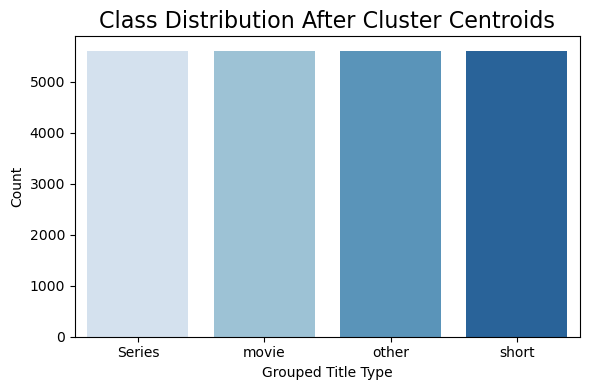


Best hyperparameters for DT after Cluster Centroids: {'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 14, 'criterion': 'gini'}

Decision Tree Classifier Report (After Cluster Centroids):
              precision    recall  f1-score   support

      Series       0.96      0.78      0.86     24448
       movie       0.80      0.79      0.79     12788
       other       0.26      0.77      0.39      2422
       short       0.91      0.90      0.90      5005

    accuracy                           0.80     44663
   macro avg       0.73      0.81      0.74     44663
weighted avg       0.87      0.80      0.82     44663



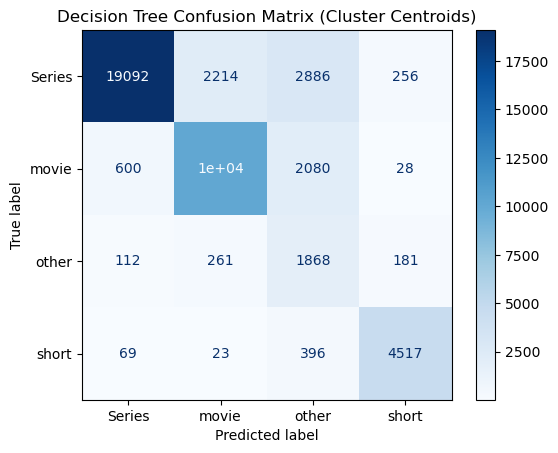

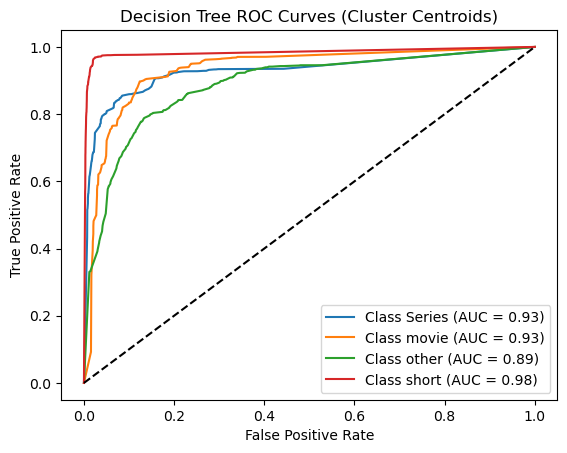

In [33]:
# =============================================================================
# Step 1: Apply Cluster Centroids Undersampling using MiniBatchKMeans
# =============================================================================
cc = ClusterCentroids(estimator=MiniBatchKMeans(n_init=1, random_state=42), random_state=42)
X_res_cc, y_res_cc = cc.fit_resample(X_train_dt_scaled, y_train_dt)

# =============================================================================
# Step 2: Plot Class Distribution After Cluster Centroids
# =============================================================================
target_counts_cc = pd.Series(y_res_cc).value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts_cc.index, y=target_counts_cc.values, hue=target_counts_cc.index, palette='Blues', legend=False)
plt.title("Class Distribution After Cluster Centroids", fontsize=16)
plt.xlabel("Grouped Title Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# =============================================================================
# Step 3: Hyperparameter Tuning Using RandomizedSearchCV
# =============================================================================
param_grid_dt = {
    'max_depth': [None] + list(range(2, 20)),
    'min_samples_split': [10, 20, 50, 100],
    'min_samples_leaf': [5, 10, 20],
    'criterion': ['gini', 'entropy']
}

random_search_cc = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_distributions=param_grid_dt,
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42),
    n_jobs=-1,
    refit=True,
    n_iter=30,
    scoring='accuracy'
)
random_search_cc.fit(X_res_cc, y_res_cc)
best_params_cc = random_search_cc.best_params_
print("\nBest hyperparameters for DT after Cluster Centroids:", best_params_cc)

# =============================================================================
# Step 4: Train & Evaluate Decision Tree Classifier Using Cluster Centroids Data
# =============================================================================
best_dt_cc = DecisionTreeClassifier(**best_params_cc, random_state=42)
best_dt_cc.fit(X_res_cc, y_res_cc)
y_pred_dt_cc = best_dt_cc.predict(X_test_dt_scaled)

print("\nDecision Tree Classifier Report (After Cluster Centroids):")
print(classification_report(y_test_dt, y_pred_dt_cc))

# =============================================================================
# Step 5: Plot Confusion Matrix
# =============================================================================
cm_cc = confusion_matrix(y_test_dt, y_pred_dt_cc)
disp_cc = ConfusionMatrixDisplay(confusion_matrix=cm_cc, display_labels=best_dt_cc.classes_)
disp_cc.plot(cmap='Blues')
plt.title("Decision Tree Confusion Matrix (Cluster Centroids)")
plt.show()

# =============================================================================
# Step 6: Plot ROC Curves for the Cluster Centroids Model
# =============================================================================
# Binarize the true labels for multiclass ROC computation
classes_cc = best_dt_cc.classes_
y_test_bin_cc = label_binarize(y_test_dt, classes=classes_cc)
y_score_cc = best_dt_cc.predict_proba(X_test_dt_scaled)

plt.figure()
for i, cls in enumerate(classes_cc):
    fpr, tpr, _ = roc_curve(y_test_bin_cc[:, i], y_score_cc[:, i])
    plt.plot(fpr, tpr, label=f'Class {cls} (AUC = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Decision Tree ROC Curves (Cluster Centroids)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

### 2.2) OverSampling

### 2.2.1) Random Oversampling

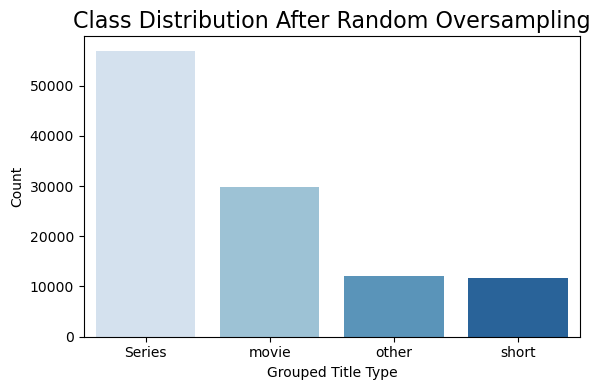


Best hyperparameters for DT after Random Oversampling: {'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 19, 'criterion': 'entropy'}

Decision Tree Classifier Report (After Random Oversampling):
              precision    recall  f1-score   support

      Series       0.95      0.85      0.89     24448
       movie       0.77      0.90      0.83     12788
       other       0.35      0.50      0.41      2422
       short       0.94      0.85      0.89      5005

    accuracy                           0.84     44663
   macro avg       0.75      0.77      0.76     44663
weighted avg       0.86      0.84      0.85     44663



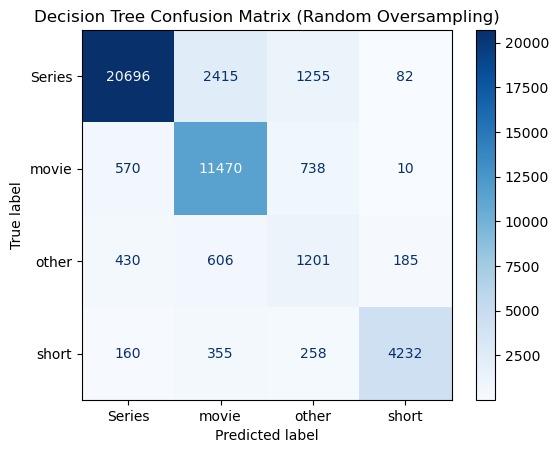

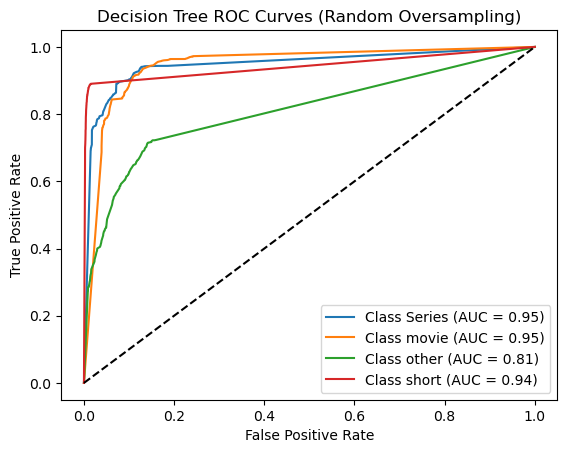

In [49]:
# =============================================================================
# Step 1: Apply Random Oversampling (ROS)
# =============================================================================
ros = RandomOverSampler(sampling_strategy={"other": 12001}, random_state=42)
X_res_ros, y_res_ros = ros.fit_resample(X_train_dt_scaled, y_train_dt)

# =============================================================================
# Step 2: Plot Class Distribution After Random Oversampling
# =============================================================================
target_counts_ros = pd.Series(y_res_ros).value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts_ros.index, y=target_counts_ros.values, hue=target_counts_ros.index, palette='Blues', legend=False)
plt.title("Class Distribution After Random Oversampling", fontsize=16)
plt.xlabel("Grouped Title Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# =============================================================================
# Step 3: Hyperparameter Tuning Using RandomizedSearchCV on ROS Data
# =============================================================================
param_grid_dt = {
    'max_depth': [None] + list(range(2, 20)),
    'min_samples_split': [10, 20, 50, 100],
    'min_samples_leaf': [5, 10, 20],
    'criterion': ['gini', 'entropy']
}

random_search_ros = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_distributions=param_grid_dt,
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42),
    n_jobs=-1,
    refit=True,
    n_iter=30,
    scoring='accuracy'
)
random_search_ros.fit(X_res_ros, y_res_ros)
best_params_ros = random_search_ros.best_params_
print("\nBest hyperparameters for DT after Random Oversampling:", best_params_ros)

# =============================================================================
# Step 4: Train & Evaluate Decision Tree Classifier Using ROS Data
# =============================================================================
best_dt_ros = DecisionTreeClassifier(**best_params_ros, random_state=42)
best_dt_ros.fit(X_res_ros, y_res_ros)
y_pred_dt_ros = best_dt_ros.predict(X_test_dt_scaled)

print("\nDecision Tree Classifier Report (After Random Oversampling):")
print(classification_report(y_test_dt, y_pred_dt_ros))

# =============================================================================
# Step 5: Plot Confusion Matrix
# =============================================================================
cm_ros = confusion_matrix(y_test_dt, y_pred_dt_ros)
disp_ros = ConfusionMatrixDisplay(confusion_matrix=cm_ros, display_labels=best_dt_ros.classes_)
disp_ros.plot(cmap='Blues')
plt.title("Decision Tree Confusion Matrix (Random Oversampling)")
plt.show()

# =============================================================================
# Step 6: Plot ROC Curves for the ROS Model
# =============================================================================
classes_ros = best_dt_ros.classes_
y_test_bin_ros = label_binarize(y_test_dt, classes=classes_ros)
y_score_ros = best_dt_ros.predict_proba(X_test_dt_scaled)

plt.figure()
for i, cls in enumerate(classes_ros):
    fpr, tpr, _ = roc_curve(y_test_bin_ros[:, i], y_score_ros[:, i])
    plt.plot(fpr, tpr, label=f'Class {cls} (AUC = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Decision Tree ROC Curves (Random Oversampling)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

### 2.2.2) SMOTE

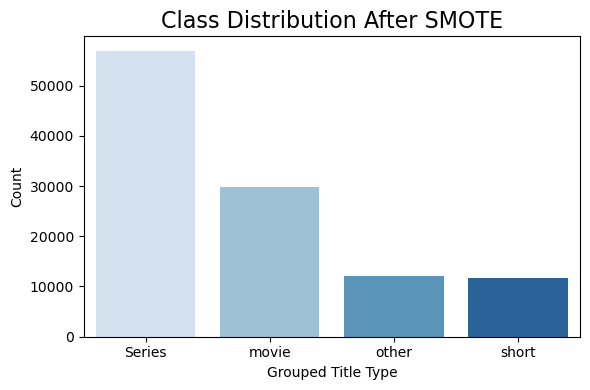


Best hyperparameters for DT after SMOTE: {'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': None, 'criterion': 'entropy'}

Decision Tree Classifier Report (After SMOTE):
              precision    recall  f1-score   support

      Series       0.95      0.85      0.90     24448
       movie       0.78      0.90      0.83     12788
       other       0.34      0.49      0.40      2422
       short       0.94      0.84      0.89      5005

    accuracy                           0.85     44663
   macro avg       0.75      0.77      0.76     44663
weighted avg       0.87      0.85      0.85     44663



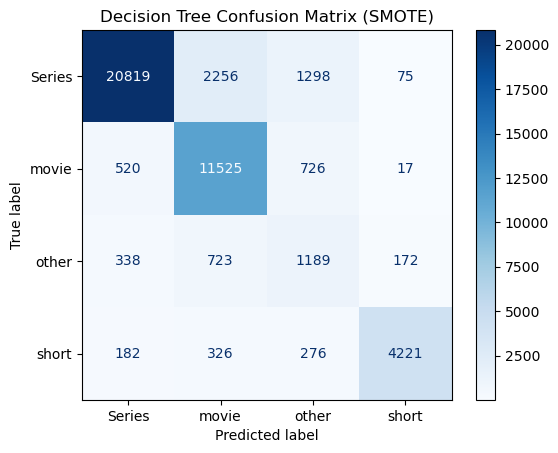

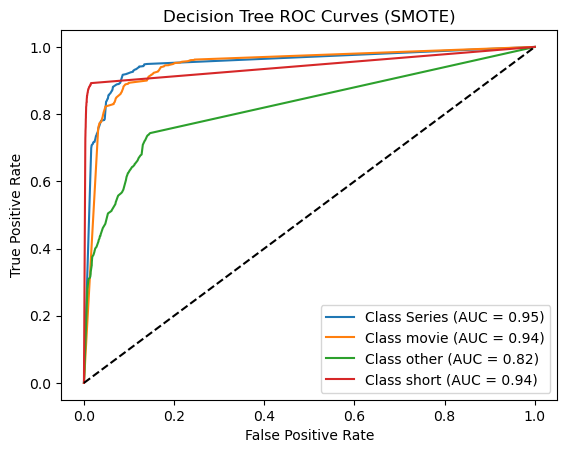

In [48]:
# =============================================================================
# Step 1: Apply SMOTE Oversampling
# =============================================================================
smote = SMOTE(sampling_strategy={"other": 12001}, random_state=42)
X_res_smote, y_res_smote = smote.fit_resample(X_train_dt_scaled, y_train_dt)

# =============================================================================
# Step 2: Plot Class Distribution After SMOTE
# =============================================================================
target_counts_smote = pd.Series(y_res_smote).value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts_smote.index, y=target_counts_smote.values, hue=target_counts_smote.index, palette='Blues', legend=False)
plt.title("Class Distribution After SMOTE", fontsize=16)
plt.xlabel("Grouped Title Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# =============================================================================
# Step 3: Hyperparameter Tuning Using RandomizedSearchCV on SMOTE Data
# =============================================================================
param_grid_dt = {
    'max_depth': [None] + list(range(10, 20)),
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10, 20],
    'criterion': ['entropy']
}

random_search_smote = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_distributions=param_grid_dt,
    cv=RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=42),
    n_jobs=-1,
    refit=True,
    n_iter=15,
    scoring='accuracy'
)
random_search_smote.fit(X_res_smote, y_res_smote)
best_params_smote = random_search_smote.best_params_
print("\nBest hyperparameters for DT after SMOTE:", best_params_smote)

# =============================================================================
# Step 4: Train & Evaluate Decision Tree Classifier Using SMOTE Data
# =============================================================================
best_dt_smote = DecisionTreeClassifier(**best_params_smote, random_state=42)
best_dt_smote.fit(X_res_smote, y_res_smote)
y_pred_dt_smote = best_dt_smote.predict(X_test_dt_scaled)

print("\nDecision Tree Classifier Report (After SMOTE):")
print(classification_report(y_test_dt, y_pred_dt_smote))

# =============================================================================
# Step 5: Plot Confusion Matrix
# =============================================================================
cm_smote = confusion_matrix(y_test_dt, y_pred_dt_smote)
disp_smote = ConfusionMatrixDisplay(confusion_matrix=cm_smote, display_labels=best_dt_smote.classes_)
disp_smote.plot(cmap='Blues')
plt.title("Decision Tree Confusion Matrix (SMOTE)")
plt.show()

# =============================================================================
# Step 6: Plot ROC Curves for the SMOTE Model
# =============================================================================
classes_smote = best_dt_smote.classes_
y_test_bin_smote = label_binarize(y_test_dt, classes=classes_smote)
y_score_smote = best_dt_smote.predict_proba(X_test_dt_scaled)

plt.figure()
for i, cls in enumerate(classes_smote):
    fpr, tpr, _ = roc_curve(y_test_bin_smote[:, i], y_score_smote[:, i])
    plt.plot(fpr, tpr, label=f'Class {cls} (AUC = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Decision Tree ROC Curves (SMOTE)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

### 2.2.3) ADASYN

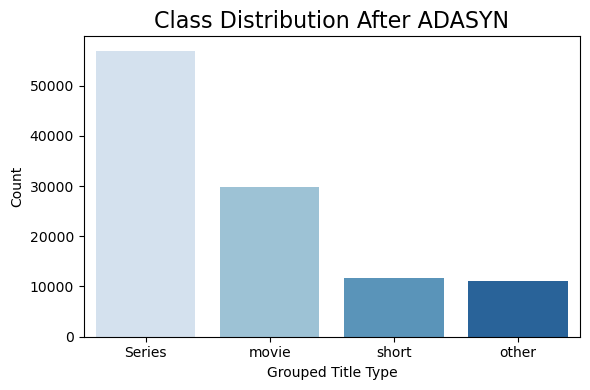


Best hyperparameters for DT after ADASYN: {'min_samples_split': 50, 'min_samples_leaf': 10, 'max_depth': 16, 'criterion': 'entropy'}

Decision Tree Classifier Report (After ADASYN):
              precision    recall  f1-score   support

      Series       0.95      0.87      0.91     24448
       movie       0.79      0.90      0.84     12788
       other       0.33      0.46      0.39      2422
       short       0.94      0.85      0.90      5005

    accuracy                           0.85     44663
   macro avg       0.76      0.77      0.76     44663
weighted avg       0.87      0.85      0.86     44663



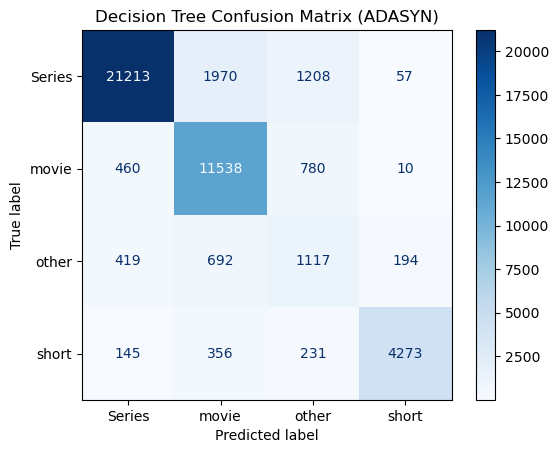

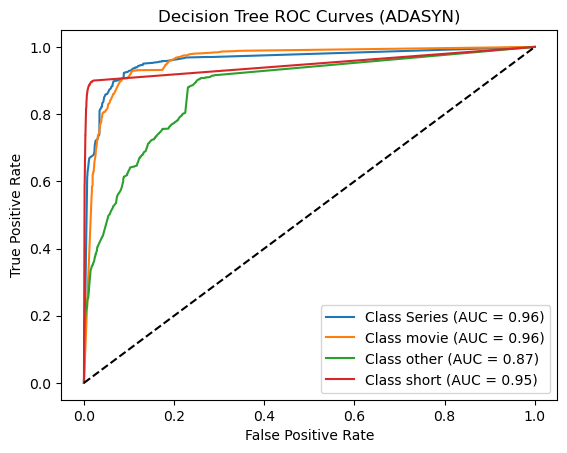

In [50]:
# =============================================================================
# Step 1: Apply ADASYN Oversampling
# =============================================================================
adasyn = ADASYN(sampling_strategy={"other": 12001}, random_state=42)
X_res_adasyn, y_res_adasyn = adasyn.fit_resample(X_train_dt_scaled, y_train_dt)

# =============================================================================
# Step 2: Plot Class Distribution After ADASYN
# =============================================================================
target_counts_adasyn = pd.Series(y_res_adasyn).value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts_adasyn.index, y=target_counts_adasyn.values, hue=target_counts_adasyn.index, palette='Blues', legend=False)
plt.title("Class Distribution After ADASYN", fontsize=16)
plt.xlabel("Grouped Title Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# =============================================================================
# Step 3: Hyperparameter Tuning Using RandomizedSearchCV on ADASYN Data
# =============================================================================
param_grid_dt = {
    'max_depth': [None] + list(range(2, 20)),
    'min_samples_split': [10, 20, 50],
    'min_samples_leaf': [5, 10, 20],
    'criterion': ['gini', 'entropy']
}

random_search_adasyn = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_distributions=param_grid_dt,
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42),
    n_jobs=-1,
    refit=True,
    n_iter=15,
    scoring='accuracy'
)
random_search_adasyn.fit(X_res_adasyn, y_res_adasyn)
best_params_adasyn = random_search_adasyn.best_params_
print("\nBest hyperparameters for DT after ADASYN:", best_params_adasyn)

# =============================================================================
# Step 4: Train & Evaluate Decision Tree Classifier Using ADASYN Data
# =============================================================================
best_dt_adasyn = DecisionTreeClassifier(**best_params_adasyn, random_state=42)
best_dt_adasyn.fit(X_res_adasyn, y_res_adasyn)
y_pred_dt_adasyn = best_dt_adasyn.predict(X_test_dt_scaled)

print("\nDecision Tree Classifier Report (After ADASYN):")
print(classification_report(y_test_dt, y_pred_dt_adasyn))

# =============================================================================
# Step 5: Plot Confusion Matrix
# =============================================================================
cm_adasyn = confusion_matrix(y_test_dt, y_pred_dt_adasyn)
disp_adasyn = ConfusionMatrixDisplay(confusion_matrix=cm_adasyn, display_labels=best_dt_adasyn.classes_)
disp_adasyn.plot(cmap='Blues')
plt.title("Decision Tree Confusion Matrix (ADASYN)")
plt.show()

# =============================================================================
# Step 6: Plot ROC Curves for the ADASYN Model
# =============================================================================
classes_adasyn = best_dt_adasyn.classes_
y_test_bin_adasyn = label_binarize(y_test_dt, classes=classes_adasyn)
y_score_adasyn = best_dt_adasyn.predict_proba(X_test_dt_scaled)

plt.figure()
for i, cls in enumerate(classes_adasyn):
    fpr, tpr, _ = roc_curve(y_test_bin_adasyn[:, i], y_score_adasyn[:, i])
    plt.plot(fpr, tpr, label=f'Class {cls} (AUC = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Decision Tree ROC Curves (ADASYN)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

### 2.2.5) SMOTEEN

In [52]:
# =============================================================================
# Step 1: Apply SMOTEENN Oversampling
# =============================================================================
"""
smoteenn = SMOTEENN(random_state=42)
X_res_smoteenn, y_res_smoteenn = smoteenn.fit_resample(X_train_dt_scaled, y_train_dt)

# =============================================================================
# Step 2: Plot Class Distribution After SMOTEENN
# =============================================================================
target_counts_smoteenn = pd.Series(y_res_smoteenn).value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts_smoteenn.index, y=target_counts_smoteenn.values, hue=target_counts_smoteenn.index, palette='Blues', legend=False)
plt.title("Class Distribution After SMOTEENN", fontsize=16)
plt.xlabel("Grouped Title Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# =============================================================================
# Step 3: Hyperparameter Tuning Using RandomizedSearchCV on SMOTEENN Data
# =============================================================================
param_grid_dt = {
    'max_depth': [None] + list(range(5, 20)),
    'min_samples_split': [10, 20, 50],
    'min_samples_leaf': [5, 10, 20],
    'criterion': ['gini', 'entropy']
}

random_search_smoteenn = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_distributions=param_grid_dt,
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42),
    n_jobs=-1,
    refit=True,
    n_iter=30,
    scoring='accuracy'
)
random_search_smoteenn.fit(X_res_smoteenn, y_res_smoteenn)
best_params_smoteenn = random_search_smoteenn.best_params_
print("\nBest hyperparameters for DT after SMOTEENN:", best_params_smoteenn)

# =============================================================================
# Step 4: Train & Evaluate Decision Tree Classifier Using SMOTEENN Data
# =============================================================================
best_dt_smoteenn = DecisionTreeClassifier(**best_params_smoteenn, random_state=42)
best_dt_smoteenn.fit(X_res_smoteenn, y_res_smoteenn)
y_pred_smoteenn = best_dt_smoteenn.predict(X_test_dt_scaled)

print("\nDecision Tree Classifier Report (After SMOTEENN):")
print(classification_report(y_test_dt, y_pred_smoteenn))

# =============================================================================
# Step 5: Plot Confusion Matrix
# =============================================================================
cm_smoteenn = confusion_matrix(y_test_dt, y_pred_smoteenn)
disp_smoteenn = ConfusionMatrixDisplay(confusion_matrix=cm_smoteenn, display_labels=best_dt_smoteenn.classes_)
disp_smoteenn.plot(cmap='Blues')
plt.title("Decision Tree Confusion Matrix (SMOTEENN)")
plt.show()

# =============================================================================
# Step 6: Plot ROC Curves for the SMOTEENN Model
# =============================================================================
classes_smoteenn = best_dt_smoteenn.classes_
y_test_bin_smoteenn = label_binarize(y_test_dt, classes=classes_smoteenn)
y_score_smoteenn = best_dt_smoteenn.predict_proba(X_test_dt_scaled)

plt.figure()
for i, cls in enumerate(classes_smoteenn):
    fpr, tpr, _ = roc_curve(y_test_bin_smoteenn[:, i], y_score_smoteenn[:, i])
    plt.plot(fpr, tpr, label=f'Class {cls} (AUC = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Decision Tree ROC Curves (SMOTEENN)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()
"""

'\nsmoteenn = SMOTEENN(random_state=42)\nX_res_smoteenn, y_res_smoteenn = smoteenn.fit_resample(X_train_dt_scaled, y_train_dt)\n\n# =============================================================================\n# Step 2: Plot Class Distribution After SMOTEENN\n# =============================================================================\ntarget_counts_smoteenn = pd.Series(y_res_smoteenn).value_counts()\nplt.figure(figsize=(6, 4))\nsns.barplot(x=target_counts_smoteenn.index, y=target_counts_smoteenn.values, hue=target_counts_smoteenn.index, palette=\'Blues\', legend=False)\nplt.title("Class Distribution After SMOTEENN", fontsize=16)\nplt.xlabel("Grouped Title Type")\nplt.ylabel("Count")\nplt.tight_layout()\nplt.show()\n\n# =============================================================================\n# Step 3: Hyperparameter Tuning Using RandomizedSearchCV on SMOTEENN Data\n# =============================================================================\nparam_grid_dt = {\n    \'max_de

### 2.3) Algorithmic-Level Adjustments

### 2.3.1.1) Adjusting Class Weights

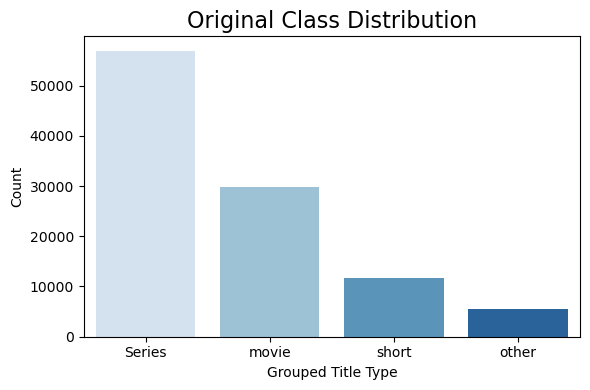


Best hyperparameters for DT with class_weight='balanced': {'min_samples_split': 10, 'min_samples_leaf': 10, 'max_depth': 19, 'criterion': 'gini'}

Decision Tree Classifier Report (Class Weights Balanced):
              precision    recall  f1-score   support

      Series       0.98      0.79      0.87     24448
       movie       0.81      0.85      0.83     12788
       other       0.26      0.69      0.37      2422
       short       0.91      0.93      0.92      5005

    accuracy                           0.81     44663
   macro avg       0.74      0.81      0.75     44663
weighted avg       0.88      0.81      0.84     44663



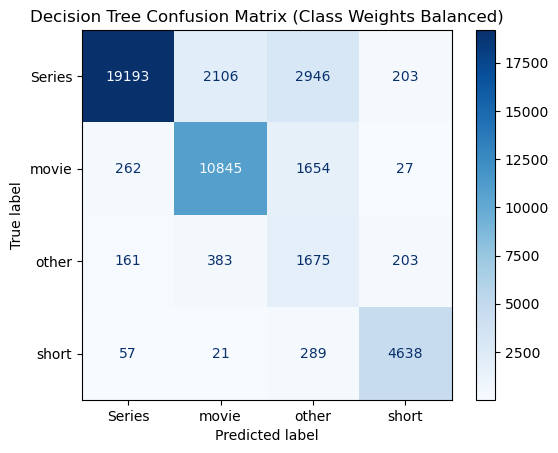

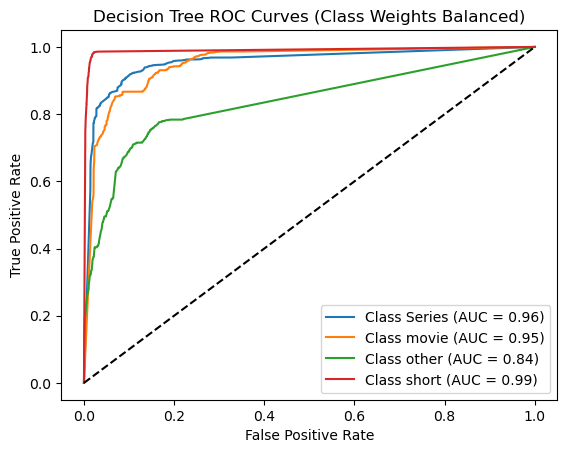

In [53]:
# =============================================================================
# Step 1: Plot Original Class Distribution (No Resampling Applied)
# =============================================================================
target_counts_orig = pd.Series(y_train_dt).value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts_orig.index, y=target_counts_orig.values, hue=target_counts_orig.index, palette='Blues', legend=False)
plt.title("Original Class Distribution", fontsize=16)
plt.xlabel("Grouped Title Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# =============================================================================
# Step 2: Hyperparameter Tuning with RandomizedSearchCV
# =============================================================================
# Define parameter grid
param_grid_dt = {
    'max_depth': [None] + list(range(2, 20)),
    'min_samples_split': [10, 20, 50, 100],
    'min_samples_leaf': [5, 10, 20],
    'criterion': ['gini', 'entropy']
}

# Initialize RandomizedSearchCV with a DT that has balanced class weights
random_search_balanced = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    param_distributions=param_grid_dt,
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42),
    n_jobs=-1,
    refit=True,
    n_iter=30,
    scoring='accuracy'
)
random_search_balanced.fit(X_train_dt_scaled, y_train_dt)
best_params_balanced = random_search_balanced.best_params_
print("\nBest hyperparameters for DT with class_weight='balanced':", best_params_balanced)

# =============================================================================
# Step 3: Train & Evaluate Decision Tree Classifier with Adjusted Class Weights
# =============================================================================
best_dt_balanced = DecisionTreeClassifier(**best_params_balanced, random_state=42, class_weight='balanced')
best_dt_balanced.fit(X_train_dt_scaled, y_train_dt)
y_pred_balanced = best_dt_balanced.predict(X_test_dt_scaled)

print("\nDecision Tree Classifier Report (Class Weights Balanced):")
print(classification_report(y_test_dt, y_pred_balanced))

# =============================================================================
# Step 4: Plot Confusion Matrix
# =============================================================================
cm_balanced = confusion_matrix(y_test_dt, y_pred_balanced)
disp_balanced = ConfusionMatrixDisplay(confusion_matrix=cm_balanced, display_labels=best_dt_balanced.classes_)
disp_balanced.plot(cmap='Blues')
plt.title("Decision Tree Confusion Matrix (Class Weights Balanced)")
plt.show()

# =============================================================================
# Step 5: Plot ROC Curves for the Balanced Model
# =============================================================================
classes_balanced = best_dt_balanced.classes_
y_test_bin_balanced = label_binarize(y_test_dt, classes=classes_balanced)
y_score_balanced = best_dt_balanced.predict_proba(X_test_dt_scaled)

plt.figure()
for i, cls in enumerate(classes_balanced):
    fpr, tpr, _ = roc_curve(y_test_bin_balanced[:, i], y_score_balanced[:, i])
    plt.plot(fpr, tpr, label=f'Class {cls} (AUC = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Decision Tree ROC Curves (Class Weights Balanced)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

### 2.3.1.2) Adjusting Class Weights Manually


Best hyperparameters for DT with manual class weights: {'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 18, 'criterion': 'gini'}

Decision Tree Classifier Report (Manual Class Weights):
              precision    recall  f1-score   support

      Series       0.97      0.76      0.85     24448
       movie       0.73      0.89      0.80     12788
       other       0.30      0.59      0.39      2422
       short       0.91      0.93      0.92      5005

    accuracy                           0.81     44663
   macro avg       0.73      0.79      0.74     44663
weighted avg       0.86      0.81      0.82     44663



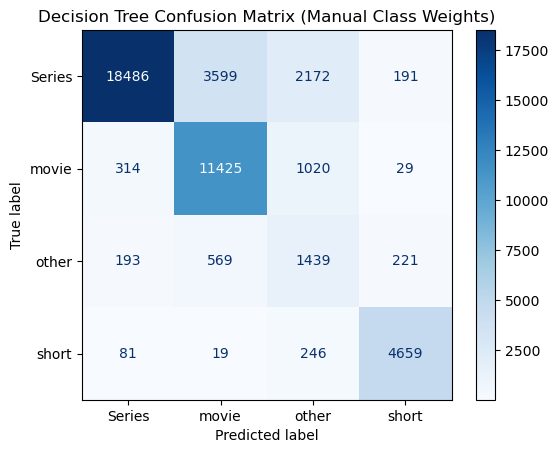

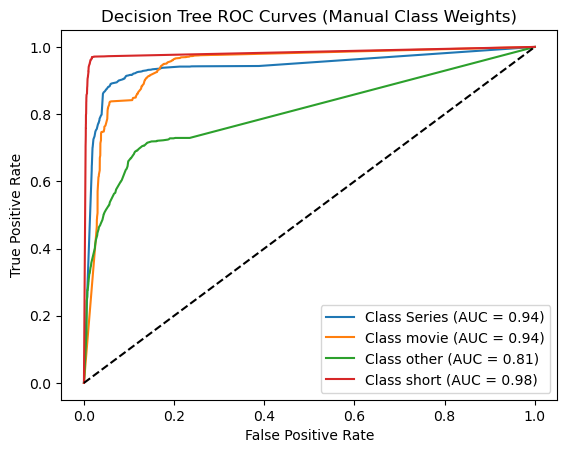

In [55]:
# =============================================================================
# Step 2: Define Manual Class Weights
# =============================================================================
# Assuming the following distribution:
# "Series": highest frequency  -> assign lower weight (e.g., 0.5)
# "movie": middle frequency     -> assign medium weight (e.g., 1.0)
# "other": highly low frequency  -> assign higher weight (e.g., 3.0)
# "series": if distinct, assign a higher weight (e.g., 2.0)
manual_class_weights = {
    'Series': 0.5,
    'movie': 1.0,
    'short': 2.0,
    'other': 3.0
}

# =============================================================================
# Step 3: Hyperparameter Tuning Using RandomizedSearchCV with Manual Class Weights
# =============================================================================
param_grid_dt = {
    'max_depth': [None] + list(range(2, 20)),
    'min_samples_split': [10, 20, 50, 100],
    'min_samples_leaf': [5, 10, 20],
    'criterion': ['gini', 'entropy']
}

random_search_manual = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42, class_weight=manual_class_weights),
    param_distributions=param_grid_dt,
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42),
    n_jobs=-1,
    refit=True,
    n_iter=30,
    scoring='accuracy'
)
random_search_manual.fit(X_train_dt_scaled, y_train_dt)
best_params_manual = random_search_manual.best_params_
print("\nBest hyperparameters for DT with manual class weights:", best_params_manual)

# =============================================================================
# Step 4: Train & Evaluate Decision Tree Classifier with Manual Class Weights
# =============================================================================
best_dt_manual = DecisionTreeClassifier(**best_params_manual, random_state=42, class_weight=manual_class_weights)
best_dt_manual.fit(X_train_dt_scaled, y_train_dt)
y_pred_manual = best_dt_manual.predict(X_test_dt_scaled)

print("\nDecision Tree Classifier Report (Manual Class Weights):")
print(classification_report(y_test_dt, y_pred_manual))

# =============================================================================
# Step 5: Plot Confusion Matrix
# =============================================================================
cm_manual = confusion_matrix(y_test_dt, y_pred_manual)
disp_manual = ConfusionMatrixDisplay(confusion_matrix=cm_manual, display_labels=best_dt_manual.classes_)
disp_manual.plot(cmap='Blues')
plt.title("Decision Tree Confusion Matrix (Manual Class Weights)")
plt.show()

# =============================================================================
# Step 6: Plot ROC Curves for the Model with Manual Class Weights
# =============================================================================
classes_manual = best_dt_manual.classes_
y_test_bin_manual = label_binarize(y_test_dt, classes=classes_manual)
y_score_manual = best_dt_manual.predict_proba(X_test_dt_scaled)

plt.figure()
for i, cls in enumerate(classes_manual):
    fpr, tpr, _ = roc_curve(y_test_bin_manual[:, i], y_score_manual[:, i])
    plt.plot(fpr, tpr, label=f'Class {cls} (AUC = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Decision Tree ROC Curves (Manual Class Weights)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

### 2.3.2) Adjusting Decision Thresholds

In [56]:
# =============================================================================
# Step 2: Hyperparameter Tuning Using RandomizedSearchCV
# =============================================================================
param_grid_dt = {
    'max_depth': [None] + list(range(2, 20)),
    'min_samples_split': [10, 20, 50, 100],
    'min_samples_leaf': [5, 10, 20],
    'criterion': ['gini', 'entropy']
}

random_search_thresh = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_distributions=param_grid_dt,
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42),
    n_jobs=-1,
    refit=True,
    n_iter=30,
    scoring='accuracy'
)
random_search_thresh.fit(X_train_dt_scaled, y_train_dt)
best_params_thresh = random_search_thresh.best_params_
print("\nBest hyperparameters for DT (default threshold):", best_params_thresh)

# =============================================================================
# Step 3: Train Decision Tree Classifier with Best Parameters
# =============================================================================
best_dt_thresh = DecisionTreeClassifier(**best_params_thresh, random_state=42)
best_dt_thresh.fit(X_train_dt_scaled, y_train_dt)

# =============================================================================
# Step 4: Adjust Decision Threshold for Each Class
# =============================================================================
def adjusted_multiclass_predict(X, clf, thresholds):
    """
    Adjusts decision thresholds for a multiclass problem.

    Parameters:
        X (array-like): Feature matrix.
        clf (classifier): Trained classifier with predict_proba method.
        thresholds (dict): Dictionary with class-specific thresholds.

    Returns:
        numpy.ndarray: Adjusted predictions (multiclass labels).
    """
    # Get predicted probabilities for each class
    y_probs = clf.predict_proba(X)

    # Initialize array to store predictions
    adjusted_preds = np.zeros_like(y_probs)

    # Apply per-class threshold adjustments
    for i, cls in enumerate(clf.classes_):
        adjusted_preds[:, i] = y_probs[:, i] > thresholds[cls]  # Apply threshold

    # Convert binary predictions back to class labels (argmax along axis=1)
    final_preds = np.argmax(adjusted_preds, axis=1)
    
    return final_preds

# Define different decision thresholds for each class (Example values)
class_thresholds = {
    'Series': 0.5, 
    'movie': 0.4, 
    'short': 0.6, 
    'other': 0.45
}

# Use adjusted_multiclass_predict function
y_pred_thresh = adjusted_multiclass_predict(X_test_dt_scaled, best_dt_thresh, class_thresholds)

print("\nDecision Tree Classifier Report (Adjusted Decision Thresholds):")
print(classification_report(y_test_dt, y_pred_thresh))

# =============================================================================
# Step 5: Plot Confusion Matrix for Adjusted Predictions
# =============================================================================
cm_thresh = confusion_matrix(y_test_dt, y_pred_thresh)
disp_thresh = ConfusionMatrixDisplay(confusion_matrix=cm_thresh, display_labels=best_dt_thresh.classes_)
disp_thresh.plot(cmap='Blues')
plt.title("Decision Tree Confusion Matrix (Adjusted Thresholds)")
plt.show()

# =============================================================================
# Step 6: Plot ROC Curves
# =============================================================================
# Binarize true labels for ROC computation
classes_thresh = best_dt_thresh.classes_
y_test_bin_thresh = label_binarize(y_test_dt, classes=classes_thresh)
y_score_thresh = best_dt_thresh.predict_proba(X_test_dt_scaled)

plt.figure()
for i, cls in enumerate(classes_thresh):
    fpr, tpr, _ = roc_curve(y_test_bin_thresh[:, i], y_score_thresh[:, i])
    plt.plot(fpr, tpr, label=f'Class {cls} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title("Decision Tree ROC Curves (Adjusted Thresholds)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


Best hyperparameters for DT (default threshold): {'min_samples_split': 50, 'min_samples_leaf': 20, 'max_depth': None, 'criterion': 'entropy'}

Decision Tree Classifier Report (Adjusted Decision Thresholds):


ValueError: Mix of label input types (string and number)